In [193]:
import pandas as pd
pd.Series

import math
import csv
from datetime import datetime

import numpy as np
import scipy as sc

import statsmodels
import sklearn
from sklearn import preprocessing

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 20
import time

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
from matplotlib import pyplot

from keras.regularizers import l1

# import BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.regularizers import l2

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score 

### Load file, print info and select columns

In [194]:
#function to load files
def load_file(filepath):
    df = pd.read_csv(filepath, sep='\t', index_col=0, parse_dates=True)
    df = df.sort_index()
    #we can check that this 2 columns are equal, so we can drop one
    #any(df['SALE_AMOUNT_BEFORE_CANCELLATIONS'] != df['SALE_AMOUNT_AFTER_CANCELLATIONS'])
    df = df.drop(['SALE_AMOUNT_AFTER_CANCELLATIONS'], axis=1)
#...
    return df.astype('float32')

#function to create a new df with selected columns
def create_small_df(df, columns):
    small_df = df.copy()
    small_df = small_df[columns]
    return small_df

#function to print inf about Data
def print_info_df(df, print_columns = False):
    #Count period
    d1 = df.index[0]
    d2 = df.index[-1]
    delta = d2 - d1
    print('Number of days is ' + str(delta.days) + ' from ' + str(d1) + ' to '+ str(d2))
    print('The shape of the data: %d*%d' %(df.shape[0],df.shape[1]))
    print('Check for Nan values: %s'%(df.isnull().values.any()))
    if (print_columns == True):
        print(list(df.columns))
    else:
        print('Number of columns: %d'%(df.shape[1]))

In [195]:
df = load_file('...')
print_info_df(df, False)

feature = 'SALE_AMOUNT'

Number of days is 1642 from 2014-01-01 00:00:00 to 2018-07-01 00:00:00
The shape of the data: 1643*23
Check for Nan values: False
Number of columns: 23


## Error Metrics

In [196]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_square_error(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def relative_rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = root_mean_square_error(y_true, y_pred)
    return (rmse / np.mean(y_true))*100

#def f_smape(A, F):
#    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def f_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 0.1
    summ = np.maximum(np.abs(y_true) + np.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = np.abs(y_pred - y_true) / summ * 2.0
    return np.mean(smape)

def summarize_results(scores):
    #print(scores)
    m, s = np.mean(scores), np.std(scores)
    #print('Mean %.4f (+/- %.4f)' % (m,s))
    return m,s

## Modelling

In [197]:
#Data Preparation
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [198]:
def preprocessing_data(data, n, s_columns):
    # normalize features
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, n, 1)
    # drop columns we don't want to predict
    columns_to_drop = list(range(-s_columns+1,0))
    reframed.drop(reframed.columns[columns_to_drop], axis=1, inplace=True)
    values = reframed.values
    return scaler, values

In [199]:
def split_data(values, n_steps,s_columns, n_train_days, n_valid_days, n_test_days):
    #print("Splitting data step")
    train = values[:n_train_days, :]
    valid = values[n_train_days : int(n_train_days + n_valid_days), :]
    test = values[int(n_train_days + n_valid_days):, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    valid_X, valid_y = valid[:, :-1], valid[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1] 
    return train_X, train_y, valid_X, valid_y, test_X, test_y

## MLP model

In [213]:
def define_fit_mlp(train_X, train_y, valid_X, valid_y, test_X,
                   test_y, n_steps, scaler, s_columns):
    s = s_columns
    n_input = 14
    #define model 
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=s*n_steps))
    model.add(Dropout(0.1))
    #model.add(Dense(100, activity_regularizer=l1(0.001)))
    model.add(Dense(1))
    model.compile(optimizer='Adagrad', loss='mse', metrics=['mse', 'mae', 'mape'])
    
    #fit model
    history =model.fit(train_X, train_y, epochs=200, validation_data=(test_X, test_y),
                       verbose=0, batch_size=n_input, shuffle=False)
    # plot
    # plot history 
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='loss_MSE', lw=2)
    plt.plot(history.history['val_loss'], label='val_loss_MSE', lw=2)
    plt.title('Training and Validation Loss')
    plt.legend(prop={'size': 15})
    plt.grid(True)
    plt.show()
    
    # evaluate model
    results = model.evaluate(test_X, test_y, verbose=0)
    loss, mse, mae, mape = results   
    print('loss=%.3f, mse=%.3f, mae=%.3f, mape=%.3f' %(loss, mse, mae, mape)) 
    print ('History results: ')
    print('Loss: %.3f - %.3f' % (history.history['loss'][0],history.history['loss'][-1]))
    print('Validation Loss: %.3f - %.3f' % (history.history['val_loss'][0],history.history['val_loss'][-1]))
      
    # make a prediction !!!!!!! 
    yhat = model.predict(test_X)
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1-s:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1-s:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = root_mean_square_error(inv_y, inv_yhat)
    rel_rmse = relative_rmse(inv_y, inv_yhat)
    mape = mean_absolute_percentage_error(inv_y, inv_yhat)

    plt.subplot(2, 1, 1)
    plt.plot(inv_yhat, label='yhat', linestyle='--', lw=2)
    plt.plot(inv_y, label='y', lw=2)
    plt.title('Observed and Predicted Values')
    plt.legend(prop={'size': 15})
    plt.grid(True)
    plt.show()
    
    return loss, rmse, mape, rel_rmse

In [201]:
def run_model(n,s,values):
    size = values.shape[0]
    n_train_days = round(size*0.9)
    n_valid_days = 0
    n_test_days = size - n_train_days - n_valid_days
    n_steps = n
    s_columns = s
    
    #Preprocessing
    scaler, new_values = preprocessing_data(values, n_steps, s_columns)
    #Split data into train and test sets
    train_X, train_y, valid_X, valid_y, test_X, test_y = split_data(new_values, n_steps,
                                                                    s_columns, n_train_days,
                                                                    n_valid_days, n_test_days)
    
    #Define and fit our MLP model
    #Make a prediction
    loss, rmse, mape, rel_rmse = define_fit_mlp(train_X, train_y, valid_X,
                                                        valid_y, test_X, test_y,
                                                        n_steps, scaler, s_columns)
    return loss, rmse, mape, rel_rmse

In [202]:
def new_run_experiment(n,s,values,feature_set=[],repeats=3):
    print("Run experiment with " + str(repeats) + " repeats")
    #print('Features set:'+ str(feature_set))
    #repeat experiment 
    losses = list()
    rmses = list()
    mapes = list()
    relative_rmses = list()
    for r in range(repeats):
        print('--------------------------------------------------------------------------------------------------------')
        print('Run #%d' % (r+1))
        start_time = time.time()
        loss, rmse, mape, rel_rmse = run_model(n,s,values)
        print('>#%d Training Loss: %.3f' % (r+1, loss))
        print('>#%d Test RMSE: %.3f' % (r+1, rmse))
        print('>#%d Test Relative RMSE: %.3f' % (r+1, rel_rmse))
        print('>#%d Test MAPE: %.3f' % (r+1, mape))
        losses.append(loss)
        rmses.append(rmse)
        mapes.append(mape)
        relative_rmses.append(rel_rmse)
        elapsed_time = time.time() - start_time
        print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    print('--------------------------------------------------------------------------------------------------------')    
    print('Final Average Results: ')
    m,s = summarize_results(losses)
    print('Loss: %.4f (s=%.4f)' % (m,s))
    m,s = summarize_results(rmses)
    print('RMSE: %.4f (s=%.4f)' % (m,s))
    m,s = summarize_results(relative_rmses)
    print('Relative RMSE: %.4f (s=%.4f)' % (m,s))
    m,s = summarize_results(mapes)
    print('MAPE: %.4f (s=%.4f)' % (m,s))

In [159]:
values = df.values.astype('float32')
feature_set = list(df.columns)
n_features = values.shape[1]

Run experiment with 3 repeats
--------------------------------------------------------------------------------------------------------
Run #1


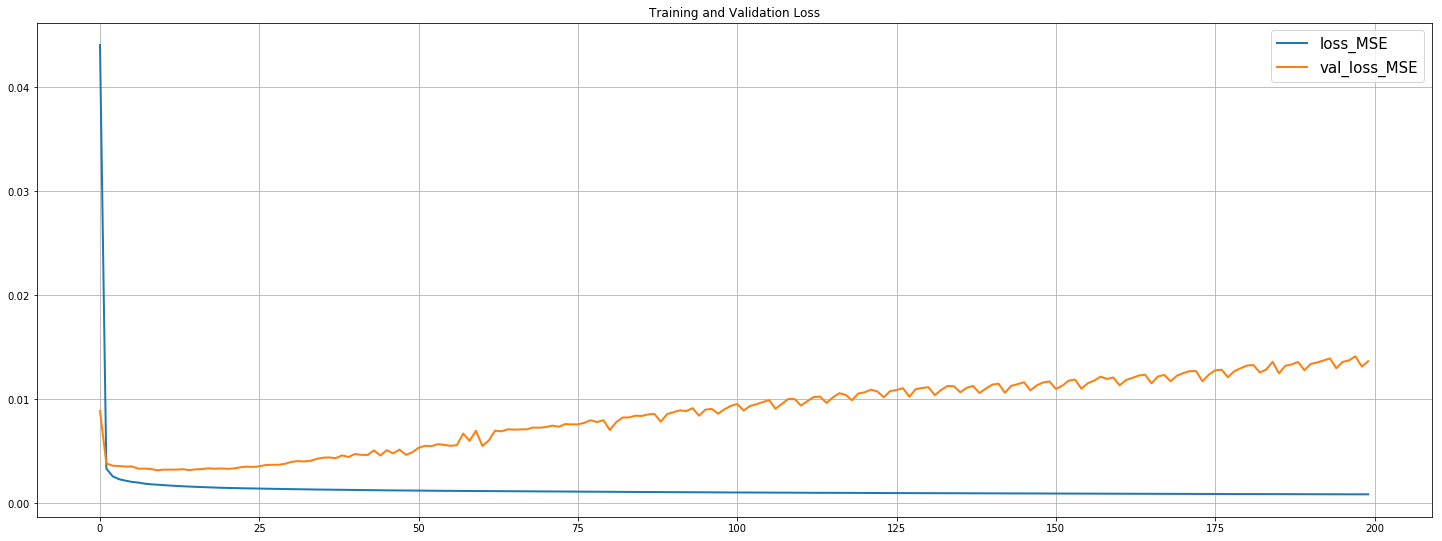

loss=0.014, mse=0.014, mae=0.078, mape=25.467
History results: 
Loss: 0.044 - 0.001
Validation Loss: 0.009 - 0.014


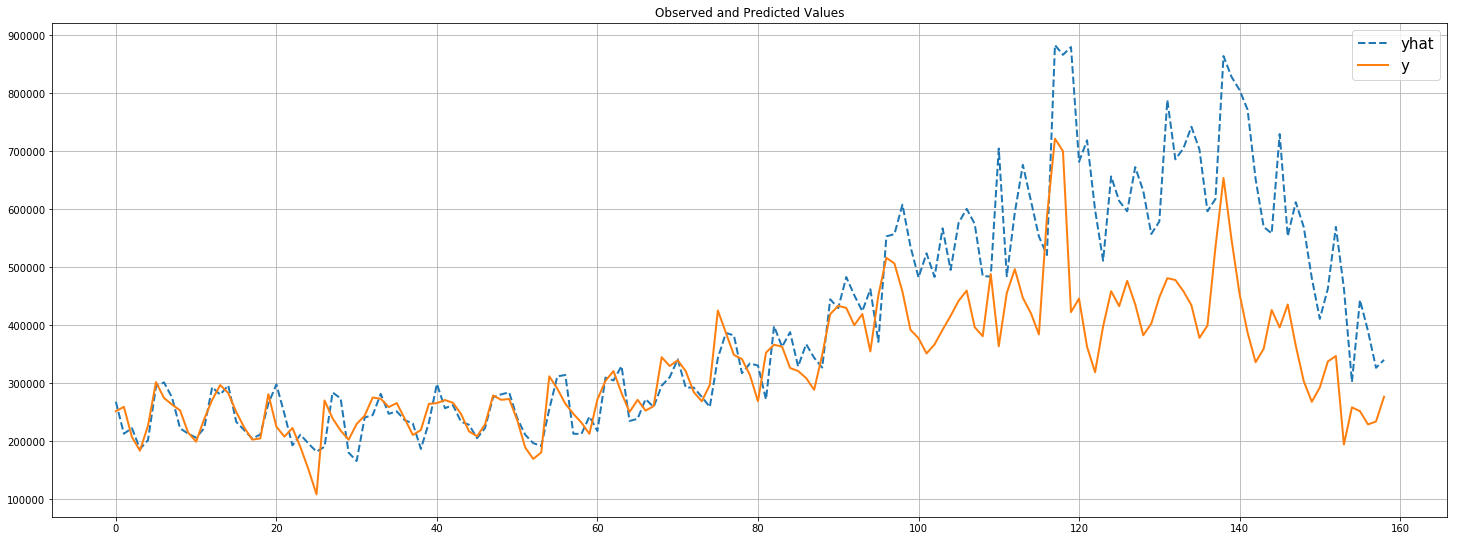

>#1 Training Loss: 0.014
>#1 Test RMSE: 135056.734
>#1 Test Relative RMSE: 40.985
>#1 Test MAPE: 25.467
00:00:23
--------------------------------------------------------------------------------------------------------
Run #2


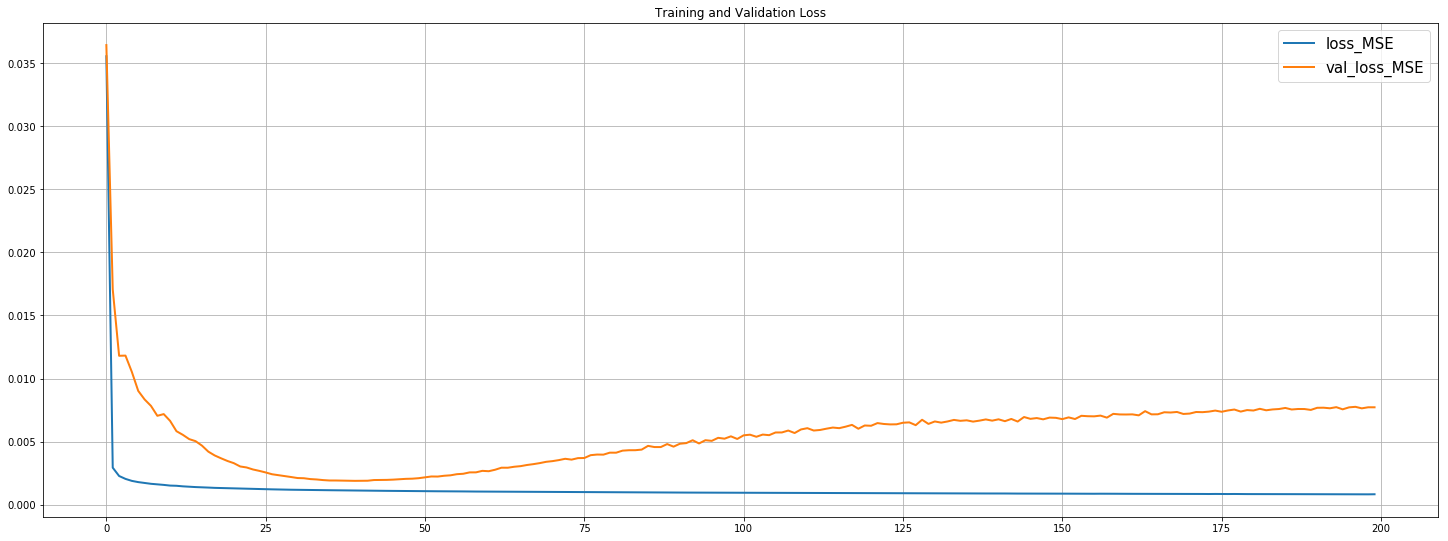

loss=0.008, mse=0.008, mae=0.059, mape=20.041
History results: 
Loss: 0.036 - 0.001
Validation Loss: 0.036 - 0.008


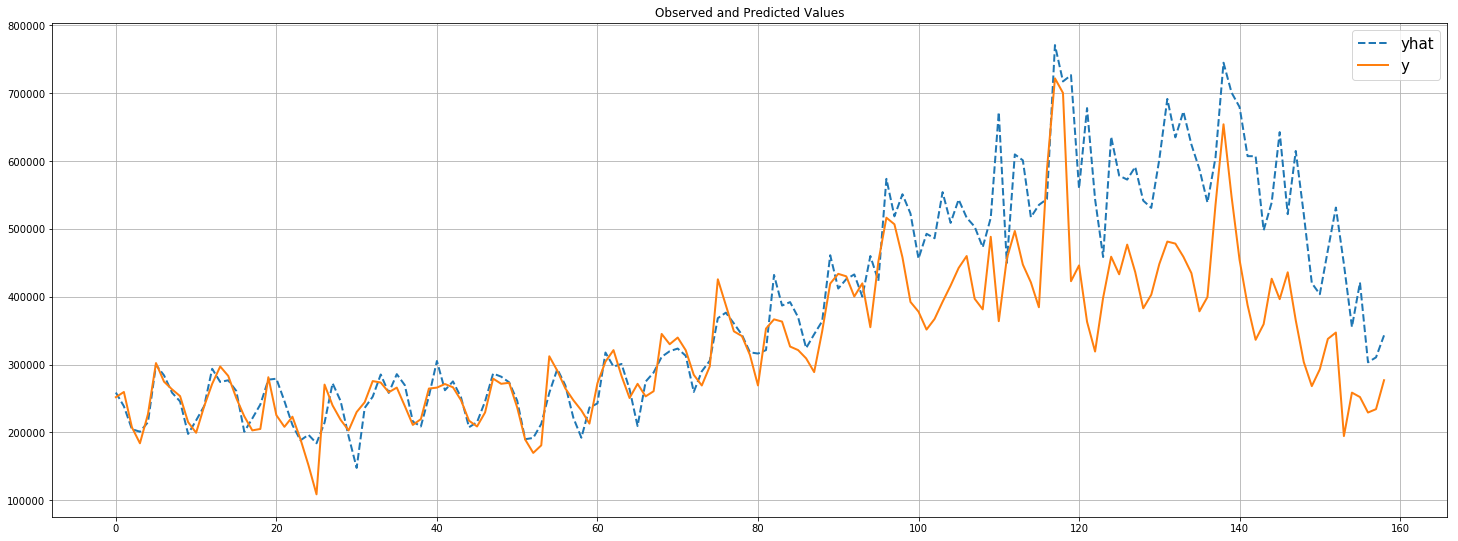

>#2 Training Loss: 0.008
>#2 Test RMSE: 101512.406
>#2 Test Relative RMSE: 30.805
>#2 Test MAPE: 20.041
00:00:23
--------------------------------------------------------------------------------------------------------
Run #3


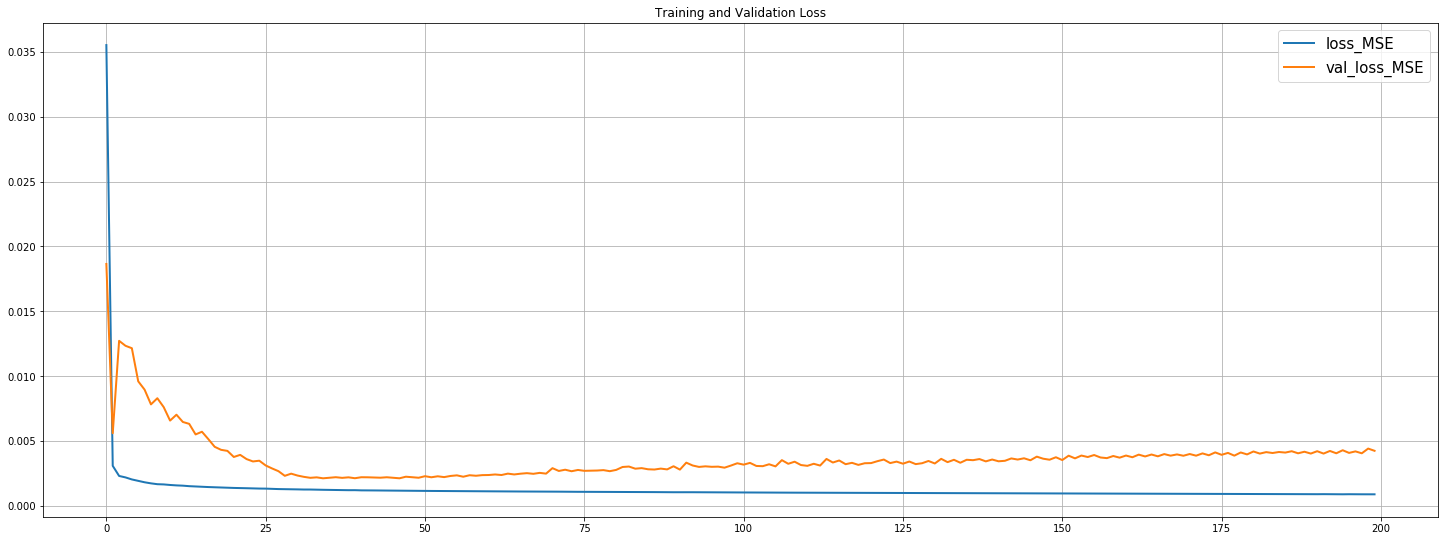

loss=0.004, mse=0.004, mae=0.047, mape=16.303
History results: 
Loss: 0.036 - 0.001
Validation Loss: 0.019 - 0.004


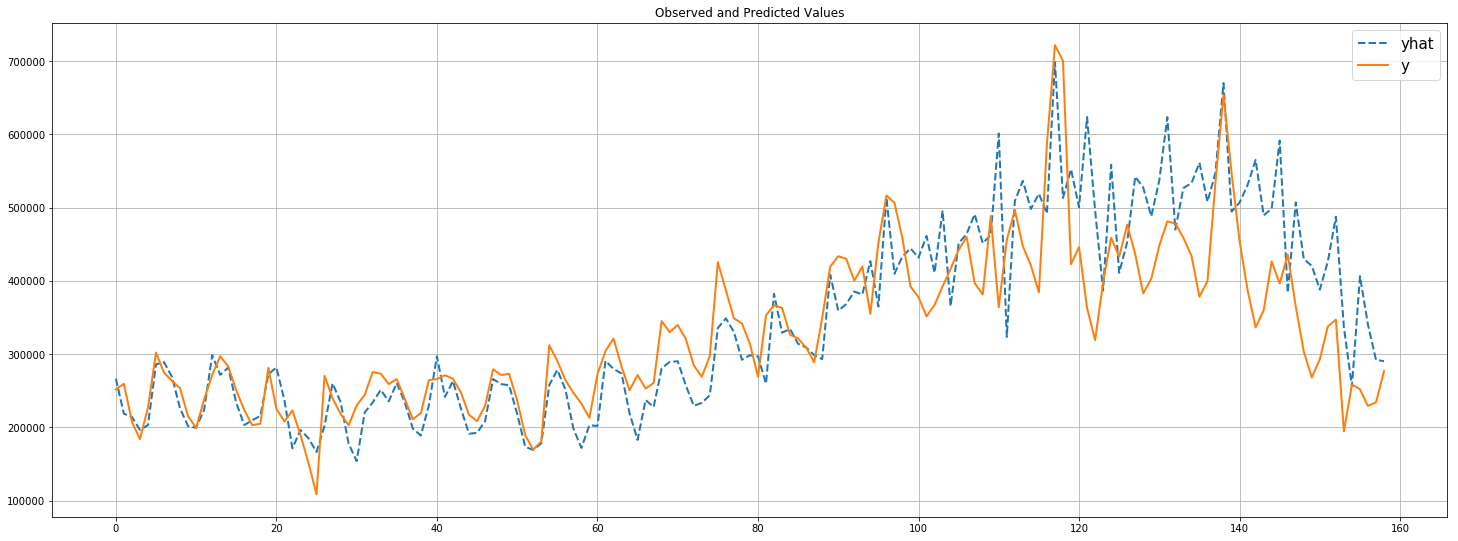

>#3 Training Loss: 0.004
>#3 Test RMSE: 75188.211
>#3 Test Relative RMSE: 22.817
>#3 Test MAPE: 16.303
00:00:20
--------------------------------------------------------------------------------------------------------
Final Average Results: 
Loss: 0.0085 (s=0.0039)
RMSE: 103919.1172 (s=24500.3984)
Relative RMSE: 31.5355 (s=7.4349)
MAPE: 20.6039 (s=3.7624)


In [160]:
new_run_experiment(5, n_features, values, feature_set)

## Select features 

In [212]:
new_features_set = [...]
new_df = create_small_df(df, new_features_set)
new_values = new_df.values

In [ ]:
new_run_experiment(1, new_df.shape[1], new_values, new_features_set)

In [ ]:
new_run_experiment(2, new_df.shape[1], new_values, new_features_set)

In [ ]:
new_run_experiment(3, new_df.shape[1], new_values, new_features_set)

In [ ]:
new_run_experiment(4, new_df.shape[1], new_values, new_features_set)

In [ ]:
new_run_experiment(5, new_df.shape[1], new_values, new_features_set)